## **Milestone 1 -  Customizing AutoKeras Blocks**

Based on the notebook of Xiaotian Han



Implement the an automated deep learning model for image classification using the Funtional API of AutoKeras. The step is listed as follows:

1. Load and prepare cifar10 dataset
2. Customize a CNN AutoKeras Block
3. Build a AutoML pipeline
4. Explore the searched model

In [ ]:
%%capture
!pip install tensorflow==2.5.0
!pip install autokeras==1.0.16

In [1]:
# import the python packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Layer, Dense, ReLU, Softmax, MaxPooling2D, Flatten, Conv2D

import autokeras as ak

from typing import Optional
from typing import Union

import tensorflow as tf
from keras_tuner.engine import hyperparameters
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.python.util import nest

from autokeras import keras_layers
from autokeras.blocks import reduction
from autokeras.engine import block as block_module
from autokeras.utils import layer_utils
from autokeras.utils import utils

print( "tf.__version__:", tf.__version__ )
print( "ak.__version__:", ak.__version__ )

tf.__version__: 2.5.0
ak.__version__: 1.0.16


## Load and prepare cifar10 dataset

#### Load dataset

In [2]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

from sklearn.utils import resample
x_train, y_train = resample(x_train, y_train, n_samples=10000, replace=False, random_state=0)

print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

Training image shape: (10000, 32, 32, 3)
Training label shape: (10000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)


#### Prepare data

In [3]:
# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

Training image shape: (10000, 32, 32, 3)
Training label shape: (10000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)


## Customize a CNN AutoKeras Block


In [4]:
class myConvBlock(ak.Block):

    def build(self, hp, inputs=None):
        inputs = tf.nest.flatten(inputs)
        input_node = inputs[0]
        output_node = input_node

        # Set a hyperparameter kernel_size, which is selected from [3, 7] wiht step 2.
        kernel_size = hp.Int(name='kernel_size', min_value=3, max_value=7, step=2)

        # Set a hyperparameter filters, which is selected from [32, 256] wiht step 32.
        filters = hp.Int(name='filters', min_value=32, max_value=256, step=32)
        
        # Use a Conv2D layer to process the inputs with the tunable hyperparameters kernel_size and filters
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(input_node)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
        output_node = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        
        return output_node


## Build a AutoML pipeline

In [5]:
inputs = ak.ImageInput()
x = ak.Normalization()(inputs)
x = ak.ImageAugmentation()(x)
# Build an AutoML pipeline using the cusomized AutoKeras block myConvBlock 
x = myConvBlock()(x)    # my custom block
outputs = ak.ClassificationHead(dropout=0.0)(x)

#### Search pipelines

In [6]:
clf = ak.AutoModel(
    inputs=inputs, 
    outputs=outputs,
    max_trials=10,
    overwrite=True,
    seed=43,
    tuner="greedy")
    # tuner="random")

In [7]:
clf.fit(x_train, y_train, epochs=10)

Trial 10 Complete [00h 00m 33s]
val_loss: 1.2222158908843994

Best val_loss So Far: 1.1894075870513916
Total elapsed time: 00h 05m 26s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
313/313 [==============================] - 2s 6ms/step - loss: 1.7627 - accuracy: 0.3512
Epoch 2/10
313/313 [==============================] - 1s 5ms/step - loss: 1.4853 - accuracy: 0.4610
Epoch 3/10
313/313 [==============================] - 1s 4ms/step - loss: 1.3580 - accuracy: 0.5152
Epoch 4/10
313/313 [==============================] - 1s 4ms/step - loss: 1.2618 - accuracy: 0.5532
Epoch 5/10
313/313 [==============================] - 1s 4ms/step - loss: 1.1835 - accuracy: 0.5786
Epoch 6/10
313/313 [==============================] - 1s 4ms/step - loss: 1.1174 - accuracy: 0.6066
Epoch 7/10
313/313 [==============================] - 1s 5ms/step - loss: 1.0776 - accuracy: 0.6191
Epoch 8/10
313/313 [==============================] - 1s 4ms/step - loss: 1.0365 - accuracy: 0.6463
Epoch 9/10
313/313 [=======

In [8]:
clf.tuner.search_space_summary()

Search space summary
Default search space size: 11
image_augmentation_1/translation_factor (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1], 'ordered': True}
image_augmentation_1/horizontal_flip (Boolean)
{'default': True, 'conditions': []}
image_augmentation_1/vertical_flip (Boolean)
{'default': True, 'conditions': []}
image_augmentation_1/rotation_factor (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1], 'ordered': True}
image_augmentation_1/zoom_factor (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1], 'ordered': True}
image_augmentation_1/contrast_factor (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1], 'ordered': True}
my_conv_block_1/kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 2, 'sampling': None}
my_conv_block_1/filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
classification_head_1/spatial_reduction_1/re

## Retrain and explore model

In [9]:
# Get the summarized results during the tuning process (return the best 10 models if existed)
clf.tuner.results_summary()

Results summary
Results in .\auto_model
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
image_augmentation_1/translation_factor: 0.0
image_augmentation_1/horizontal_flip: True
image_augmentation_1/vertical_flip: True
image_augmentation_1/rotation_factor: 0.0
image_augmentation_1/zoom_factor: 0.0
image_augmentation_1/contrast_factor: 0.0
my_conv_block_1/kernel_size: 3
my_conv_block_1/filters: 128
classification_head_1/spatial_reduction_1/reduction_type: flatten
optimizer: adam
learning_rate: 0.001
Score: 1.1894075870513916
Trial summary
Hyperparameters:
image_augmentation_1/translation_factor: 0.0
image_augmentation_1/horizontal_flip: True
image_augmentation_1/vertical_flip: True
image_augmentation_1/rotation_factor: 0.0
image_augmentation_1/zoom_factor: 0.1
image_augmentation_1/contrast_factor: 0.0
my_conv_block_1/kernel_size: 3
my_conv_block_1/filters: 128
classification_head_1/spatial_reduction_1/reduction_type: flatten
optimizer: ada

In [10]:
#Retrieve best model
best_model = clf.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 32, 32, 3)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
random_flip (RandomFlip)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       147584

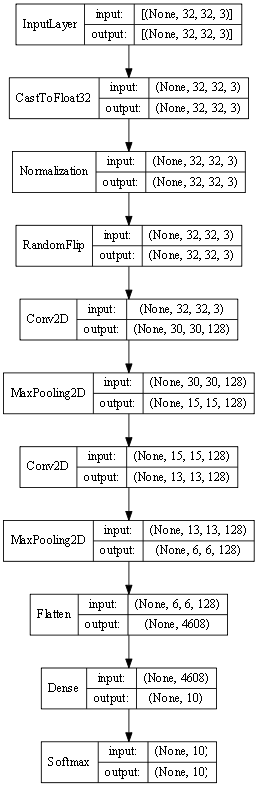

In [11]:
# Converts a Keras model to dot format and plot an image
tf.keras.utils.plot_model(best_model, show_layer_names=False, show_shapes=True, expand_nested=True, dpi=64)

#### Retrain the searched model

In [12]:
(x_train, y_train), (x_test, y_test) =  cifar10.load_data()
# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

# compile the model and train the model
best_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
best_model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.20)

Training image shape: (50000, 32, 32, 3)
Training label shape: (50000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)
Epoch 1/50
625/625 [==============================] - 6s 7ms/step - loss: 1.0700 - accuracy: 0.6282 - val_loss: 1.0048 - val_accuracy: 0.6543
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 0.9920 - accuracy: 0.6557 - val_loss: 0.9510 - val_accuracy: 0.6684
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9458 - accuracy: 0.6722 - val_loss: 0.9528 - val_accuracy: 0.6720
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.9099 - accuracy: 0.6830 - val_loss: 0.9281 - val_accuracy: 0.6786
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8910 - accuracy: 0.6880 - val_loss: 0.9548 - val_accuracy: 0.6682
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8666 - accuracy: 0.6988 - val_loss: 0.9403 - val_accuracy: 0.6729
Ep

#### Evaluate the searched model

In [13]:
# evaluate the model
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.9225 - accuracy: 0.7068
Test loss:  0.9225427508354187
Test accuracy:  0.7067999839782715


Save and load the model

In [14]:
from tensorflow.keras.models import load_model

try:
    best_model.save("best_model_autokeras_5_1", save_format="tf")
except Exception:
    best_model.save("best_model_autokeras.h5")

INFO:tensorflow:Assets written to: best_model_autokeras_5_1\assets


In [15]:
loaded_model = load_model("best_model_autokeras_5_1", custom_objects=ak.CUSTOM_OBJECTS)